In [1]:
import matplotlib.pyplot as plt

In [2]:
import torch, torchvision
import numpy as np
rng = np.random.default_rng()
import time
from tqdm.notebook import tqdm   ### suitable for notebooks

In [3]:
fname = 'MNIST_torch'

### Download and initialize datasets
TrainDS_orig = torchvision.datasets.MNIST(fname, train=True, download=True)
TestDS_orig = torchvision.datasets.MNIST(fname, train=False)

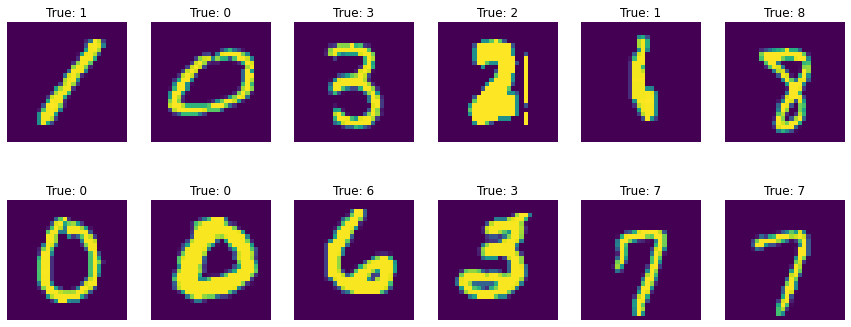

In [4]:
### Plot examples
fig, axes = plt.subplots(nrows=2, ncols=6, figsize=(15., 6.))
for axes_row in axes:
    for ax in axes_row:
        test_index = rng.integers(0, len(TestDS_orig))
        image, orig_label = TestDS_orig[test_index]
        ax.set_axis_off()
        ax.imshow(image)
        ax.set_title('True: %i' % orig_label)

In [5]:
### Define the label transform from an integer to a set of probabilities
def target_transform(inlabel):
    newlabel = torch.zeros(10)
    newlabel[inlabel] = 1.
    return newlabel

### Reinitialize datasets with the transforms
TrainDS = torchvision.datasets.MNIST(fname, train=True, download=True,
            target_transform=target_transform, transform=torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                              torchvision.transforms.Normalize((0.1307), (0.3081)),
                             ]))
TestDS = torchvision.datasets.MNIST(fname, train=False,
            target_transform=target_transform, transform=torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                              torchvision.transforms.Normalize((0.1307), (0.3081)),
                             ]))

### Initialize DataLoaders as PyTorch convenience
TrainDL = torch.utils.data.DataLoader(TrainDS, shuffle=True, batch_size=32)
TestDL = torch.utils.data.DataLoader(TestDS, batch_size=1000)

### Choose device: 'cuda' or 'cpu'
device = 'cpu'
# device = 'cuda'

### Define the dense neuron layer
# Network = torch.nn.Sequential(
#     torch.nn.Flatten(),            # 28x28 -> 784
#     torch.nn.Linear(784, 10),      # 784 -> 10
#     torch.nn.Softmax(dim=1)
# )
Network = torch.nn.Sequential(
    torch.nn.Flatten(),
    torch.nn.Linear(784, 256),
    torch.nn.ReLU(),
    torch.nn.Linear(256, 10),
    torch.nn.Softmax(dim=1)
)
Network.to(device=device)

### Get information about model
totpars = 0
for par in Network.parameters():
    newpars = 1
    for num in par.shape:
        newpars *= num
    totpars += newpars
print(Network)
print('%i trainable parameters' % totpars)

### Initialize loss function and optimizer
crit = torch.nn.BCELoss()
# crit = torch.nn.CrossEntropyLoss()
opt = torch.optim.SGD(Network.parameters(), lr=0.4)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): ReLU()
  (3): Linear(in_features=256, out_features=10, bias=True)
  (4): Softmax(dim=1)
)
203530 trainable parameters


In [6]:
### Baseline: just say it's anything at probability 1/N, what's the loss?
N = 10
labels = torch.zeros(1, 10, dtype=torch.float32)
labels[0, 3] = 1.
output = torch.full_like(labels, 1./N)
print(crit(output, labels))

tensor(0.3251)


In [7]:
### Set model in training mode and create the epochs axis
Network.train()
epochs = range(1, 101)

### Train the model
for e in tqdm(epochs):
    tr_loss = 0.
    samples = 0
    ### Loop over batches
    for inputs, labels in tqdm(TrainDL, leave=False):
        opt.zero_grad() # zero gradient values
        inputs = inputs.to(device=device) # move input and label tensors to the device with the model
        labels = labels.to(device=device)
        outputs = Network(inputs) # compute model outputs
        loss = crit(outputs, labels) # compute batch loss
        loss.backward() # back-propagate the gradients
        opt.step() # update the model weights
        tr_loss += loss.clone().cpu().item()*len(inputs) # add the batch loss to the running loss
        samples += len(inputs) # update the number of processed samples
    tr_loss /= samples # compute training loss
    print(e, tr_loss)

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

1 0.04007439887722333


  0%|          | 0/1875 [00:00<?, ?it/s]

2 0.017039514523092658


  0%|          | 0/1875 [00:00<?, ?it/s]

3 0.011846467770488622


  0%|          | 0/1875 [00:00<?, ?it/s]

4 0.00875460035520761


  0%|          | 0/1875 [00:00<?, ?it/s]

5 0.006563040668216611


  0%|          | 0/1875 [00:00<?, ?it/s]

6 0.004888626126663681


  0%|          | 0/1875 [00:00<?, ?it/s]

7 0.0039214819269487635


  0%|          | 0/1875 [00:00<?, ?it/s]

8 0.002780100645402369


  0%|          | 0/1875 [00:00<?, ?it/s]

9 0.0020984672929514393


  0%|          | 0/1875 [00:00<?, ?it/s]

10 0.0014454079161204088


  0%|          | 0/1875 [00:00<?, ?it/s]

11 0.0010382845471234759


  0%|          | 0/1875 [00:00<?, ?it/s]

12 0.0007959990120769362


  0%|          | 0/1875 [00:00<?, ?it/s]

13 0.0006002914236515305


  0%|          | 0/1875 [00:00<?, ?it/s]

14 0.0005038187846332828


  0%|          | 0/1875 [00:00<?, ?it/s]

15 0.0004245510680621616


  0%|          | 0/1875 [00:00<?, ?it/s]

16 0.000363152128033956


  0%|          | 0/1875 [00:00<?, ?it/s]

17 0.00030326430510649517


  0%|          | 0/1875 [00:00<?, ?it/s]

18 0.0002668538012629445


  0%|          | 0/1875 [00:00<?, ?it/s]

19 0.0002336064372319015


  0%|          | 0/1875 [00:00<?, ?it/s]

20 0.0002146033658888579


  0%|          | 0/1875 [00:00<?, ?it/s]

21 0.0001988056042585716


  0%|          | 0/1875 [00:00<?, ?it/s]

22 0.00018218161480745037


  0%|          | 0/1875 [00:00<?, ?it/s]

23 0.00016931361909555562


  0%|          | 0/1875 [00:00<?, ?it/s]

24 0.00015756270479838955


  0%|          | 0/1875 [00:00<?, ?it/s]

25 0.00014812234471573902


  0%|          | 0/1875 [00:00<?, ?it/s]

26 0.00013939899856914054


  0%|          | 0/1875 [00:00<?, ?it/s]

27 0.0001321939107705475


  0%|          | 0/1875 [00:00<?, ?it/s]

28 0.00012532459811782245


  0%|          | 0/1875 [00:00<?, ?it/s]

29 0.00011930957767135623


  0%|          | 0/1875 [00:00<?, ?it/s]

30 0.00011305112825765112


  0%|          | 0/1875 [00:00<?, ?it/s]

31 0.00010887659797829959


  0%|          | 0/1875 [00:00<?, ?it/s]

32 0.0001038507708445195


  0%|          | 0/1875 [00:00<?, ?it/s]

33 9.969435027987856e-05


  0%|          | 0/1875 [00:00<?, ?it/s]

34 9.554930989027829e-05


  0%|          | 0/1875 [00:00<?, ?it/s]

35 9.142787215335678e-05


  0%|          | 0/1875 [00:00<?, ?it/s]

36 8.845396751779238e-05


  0%|          | 0/1875 [00:00<?, ?it/s]

37 8.520790956660373e-05


  0%|          | 0/1875 [00:00<?, ?it/s]

38 8.23987814906559e-05


  0%|          | 0/1875 [00:00<?, ?it/s]

39 7.933584262467168e-05


  0%|          | 0/1875 [00:00<?, ?it/s]

40 7.666673682501066e-05


  0%|          | 0/1875 [00:00<?, ?it/s]

41 7.418934361026004e-05


  0%|          | 0/1875 [00:00<?, ?it/s]

42 7.204861803388667e-05


  0%|          | 0/1875 [00:00<?, ?it/s]

43 6.972595713635504e-05


  0%|          | 0/1875 [00:00<?, ?it/s]

44 6.756458589758646e-05


  0%|          | 0/1875 [00:00<?, ?it/s]

45 6.579571749148272e-05


  0%|          | 0/1875 [00:00<?, ?it/s]

46 6.405997648735138e-05


  0%|          | 0/1875 [00:00<?, ?it/s]

47 6.246709492164275e-05


  0%|          | 0/1875 [00:00<?, ?it/s]

48 6.0726149444099064e-05


  0%|          | 0/1875 [00:00<?, ?it/s]

49 5.9152779767115744e-05


  0%|          | 0/1875 [00:00<?, ?it/s]

50 5.7774044763027635e-05


  0%|          | 0/1875 [00:00<?, ?it/s]

51 5.6239481466082e-05


  0%|          | 0/1875 [00:00<?, ?it/s]

52 5.486246088339612e-05


  0%|          | 0/1875 [00:00<?, ?it/s]

53 5.365166592904795e-05


  0%|          | 0/1875 [00:00<?, ?it/s]

54 5.23404523809063e-05


  0%|          | 0/1875 [00:00<?, ?it/s]

55 5.120154398134673e-05


  0%|          | 0/1875 [00:00<?, ?it/s]

56 5.000065131071097e-05


  0%|          | 0/1875 [00:00<?, ?it/s]

57 4.889128993307471e-05


  0%|          | 0/1875 [00:00<?, ?it/s]

58 4.7901464542951545e-05


  0%|          | 0/1875 [00:00<?, ?it/s]

59 4.684436097921795e-05


  0%|          | 0/1875 [00:00<?, ?it/s]

60 4.5851395411394455e-05


  0%|          | 0/1875 [00:00<?, ?it/s]

61 4.495040370164437e-05


  0%|          | 0/1875 [00:00<?, ?it/s]

62 4.4077750684042866e-05


  0%|          | 0/1875 [00:00<?, ?it/s]

63 4.3313616738350904e-05


  0%|          | 0/1875 [00:00<?, ?it/s]

64 4.235740563547855e-05


  0%|          | 0/1875 [00:00<?, ?it/s]

65 4.165224323379561e-05


  0%|          | 0/1875 [00:00<?, ?it/s]

66 4.0884367351501774e-05


  0%|          | 0/1875 [00:00<?, ?it/s]

67 4.008183989429881e-05


  0%|          | 0/1875 [00:00<?, ?it/s]

68 3.936376668974238e-05


  0%|          | 0/1875 [00:00<?, ?it/s]

69 3.864405675822127e-05


  0%|          | 0/1875 [00:00<?, ?it/s]

70 3.801472377576829e-05


  0%|          | 0/1875 [00:00<?, ?it/s]

71 3.7349731362390535e-05


  0%|          | 0/1875 [00:00<?, ?it/s]

72 3.6725295657591533e-05


  0%|          | 0/1875 [00:00<?, ?it/s]

73 3.60137983533491e-05


  0%|          | 0/1875 [00:00<?, ?it/s]

74 3.547694310428634e-05


  0%|          | 0/1875 [00:00<?, ?it/s]

75 3.4977731792935176e-05


  0%|          | 0/1875 [00:00<?, ?it/s]

76 3.434269068936449e-05


  0%|          | 0/1875 [00:00<?, ?it/s]

77 3.3859511022647364e-05


  0%|          | 0/1875 [00:00<?, ?it/s]

78 3.328016153871545e-05


  0%|          | 0/1875 [00:00<?, ?it/s]

79 3.282122106329742e-05


  0%|          | 0/1875 [00:00<?, ?it/s]

80 3.231691182811573e-05


  0%|          | 0/1875 [00:00<?, ?it/s]

81 3.1872106688945224e-05


  0%|          | 0/1875 [00:00<?, ?it/s]

82 3.139035614869196e-05


  0%|          | 0/1875 [00:00<?, ?it/s]

83 3.091352213818936e-05


  0%|          | 0/1875 [00:00<?, ?it/s]

84 3.048362124554084e-05


  0%|          | 0/1875 [00:00<?, ?it/s]

85 3.0048034692280604e-05


  0%|          | 0/1875 [00:00<?, ?it/s]

86 2.9653997450733034e-05


  0%|          | 0/1875 [00:00<?, ?it/s]

87 2.9198177776887254e-05


  0%|          | 0/1875 [00:00<?, ?it/s]

88 2.882806455381039e-05


  0%|          | 0/1875 [00:00<?, ?it/s]

89 2.8459259226406176e-05


  0%|          | 0/1875 [00:00<?, ?it/s]

90 2.8107284353255105e-05


  0%|          | 0/1875 [00:00<?, ?it/s]

91 2.769928467531789e-05


  0%|          | 0/1875 [00:00<?, ?it/s]

92 2.73535281306863e-05


  0%|          | 0/1875 [00:00<?, ?it/s]

93 2.6997933212805947e-05


  0%|          | 0/1875 [00:00<?, ?it/s]

94 2.6626019546305694e-05


  0%|          | 0/1875 [00:00<?, ?it/s]

95 2.6329254072269728e-05


  0%|          | 0/1875 [00:00<?, ?it/s]

96 2.5988477483110728e-05


  0%|          | 0/1875 [00:00<?, ?it/s]

97 2.5641093681595824e-05


  0%|          | 0/1875 [00:00<?, ?it/s]

98 2.5297831071804923e-05


  0%|          | 0/1875 [00:00<?, ?it/s]

99 2.5088351420619876e-05


  0%|          | 0/1875 [00:00<?, ?it/s]

100 2.475762682890945e-05


In [8]:
### Set model in evaluation mode
Network.eval()

### Compute the test loss
with torch.no_grad():
    te_loss = 0.
    samples = 0
    accuracy = 0
    ### Loop over batches
    for inputs, labels in tqdm(TestDL):
        inputs = inputs.to(device=device)
        labels = labels.to(device=device)
#         print(labels)
        outputs = Network(inputs)
        loss = crit(outputs, labels)
        te_loss += loss.clone().cpu().item()*len(inputs)
        accuracy += torch.sum(torch.eq(torch.max(labels, 1)[1], torch.max(outputs, 1)[1]), dtype=int).clone().cpu().item()
        samples += len(inputs)
    te_loss /= samples
    accuracy /= samples
    print('Test loss: %f, accuracy: %f' % (te_loss, accuracy))

  0%|          | 0/10 [00:00<?, ?it/s]

Test loss: 0.014178, accuracy: 0.982500


In [9]:
torch.save(Network, 'model_torch_MNIST_bh.chk')

In [10]:
Network = torch.load('model_torch_MNIST_bh.chk')
device='cpu'

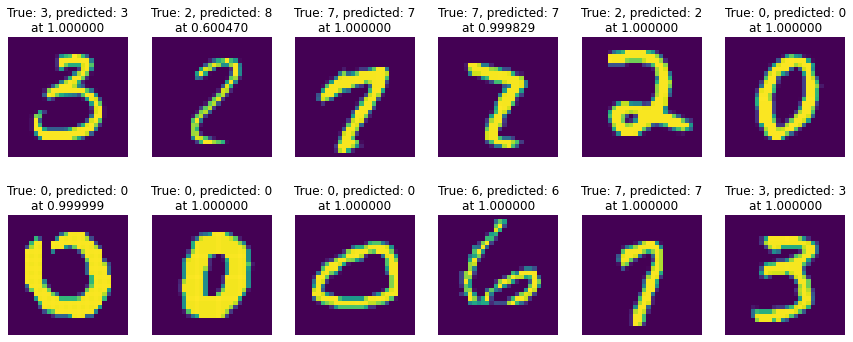

In [11]:
### Draw some random images from the test dataset and compare the true labels to the network outputs
fig, axes = plt.subplots(nrows=2, ncols=6, figsize=(15., 6.))
### Loop over subplots
for axes_row in axes:
    for ax in axes_row:
        ### Draw the images
        test_index = rng.integers(0, len(TestDS))
        sample, label = TestDS[test_index]
        image, orig_label = TestDS_orig[test_index]
        ### Compute the predictions
        with torch.no_grad():
            output = Network(torch.unsqueeze(sample, dim=0).to(device=device))
            certainty, output = torch.max(output[0], 0)
            certainty = certainty.clone().cpu().item()
            output = output.clone().cpu().item()
        ### Show image
        ax.set_axis_off()
        ax.imshow(image)
        ax.set_title('True: %i, predicted: %i\nat %f' % (orig_label, output, certainty))

In [12]:
print(sample.max())
print(sample.min())
print(sample.mean())
print(sample.shape)
print(torch.unsqueeze(sample, dim=0).shape)

tensor(2.8215)
tensor(-0.4242)
tensor(0.0898)
torch.Size([1, 28, 28])
torch.Size([1, 1, 28, 28])


(135, 114)
(145, 124)
5 5

tensor([[3.8320e-08, 9.1780e-04, 1.1566e-03, 9.9559e-01, 2.2835e-03, 4.7969e-05,
         1.8530e-09, 1.4445e-10, 8.0962e-06, 1.2068e-11]])
3
tensor([0.9956, 0.0023, 0.0012])
tensor([3, 4, 2])


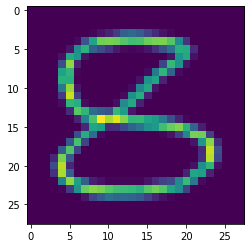

In [29]:
from PIL import ImageTk, Image, ImageDraw
import PIL
from tkinter import *
import cv2

width = 200  # canvas width
height = 200 # canvas height
center = height//2
white = (255, 255, 255) # canvas back

def save():
    # save image to hard drive
    filename = "user_input.png"
    global output_image 
    output_image.save(filename)
    ###### Centering begin
    # Load image as grayscale and obtain bounding box coordinates
    image = cv2.imread('user_input.png', 0)
    height, width = image.shape
    x,y,w,h = cv2.boundingRect(image)


    # Create new blank image and shift ROI to new coordinates
    ROI = image[y:y+h, x:x+w]
    mask = np.zeros([ROI.shape[0]+10,ROI.shape[1]+10])
    width, height = mask.shape
    print(ROI.shape)
    print(mask.shape)
    x = width//2 - ROI.shape[0]//2 
    y = height//2 - ROI.shape[1]//2 
    print(x,y)
    mask[y:y+h, x:x+w] = ROI

    # Check if centering/masking was successful
#     plt.imshow(mask, cmap='viridis') 
    output_image = PIL.Image.fromarray(mask) # mask has values in [0-255] as expected
    # Now we need to resize, but it causes problems with default arguments as it changes the range of pixel values to be negative or positive
    # compressed_output_image = output_image.resize((22,22))
    # Therefore, we use the following:
    compressed_output_image = output_image.resize((22,22), PIL.Image.BILINEAR) # PIL.Image.NEAREST or PIL.Image.BILINEAR also performs good
#     # Enhance Saturation
#     converter = PIL.ImageEnhance.Color(compressed_output_image)
#     compressed_output_image = converter.enhance(2.5)
    # Enhance contrast
#     converter = PIL.ImageEnhance.Contrast(compressed_output_image)
#     compressed_output_image = converter.enhance(3.5)
    convert_tensor = torchvision.transforms.ToTensor()
    tensor_image = convert_tensor(compressed_output_image)
    # Another problem we face is that in the above ToTensor() command, we should have gotten a normalized tensor with pixel values in [0,1]
    # But somehow it doesn't happen. Therefore, we need to normalize manually
    tensor_image = tensor_image/255.
    # Padding
    tensor_image = torch.nn.functional.pad(tensor_image, (3,3,3,3), "constant", 0)
    # Normalization shoudl be done after padding i guess
    convert_tensor = torchvision.transforms.Normalize((0.1307), (0.3081))
    tensor_image = convert_tensor(tensor_image)
    plt.imshow(tensor_image.detach().cpu().numpy().reshape(28,28), cmap='viridis')
    # Debugging
#     print(tensor_image)
#     print(np.array(compressed_output_image.getdata())) # Get data values)
#     print(np.array(image.getdata()))

    ### Compute the predictions
    print()
    with torch.no_grad():
#         print(tensor_image)
        output0 = Network(torch.unsqueeze(tensor_image, dim=0).to(device=device))
        print(output0)
        certainty, output = torch.max(output0[0], 0)
        certainty = certainty.clone().cpu().item()
        output = output.clone().cpu().item()
        certainty1, output1 = torch.topk(output0[0],3)
        certainty1 = certainty1.clone().cpu()#.item()
        output1 = output1.clone().cpu()#.item()
#     print(certainty)
    print(output)
        
    print(certainty1)
    print(output1)

def paint(event):
    x1, y1 = (event.x - 1), (event.y - 1)
    x2, y2 = (event.x + 1), (event.y + 1)
#     canvas.create_oval(x1, y1, x2, y2, fill="white",width=24)
    canvas.create_rectangle(x1, y1, x2, y2, fill="white",width=12)
    draw.line([x1, y1, x2, y2],fill="white",width=6)

master = Tk()

# create a tkinter canvas to draw on
canvas = Canvas(master, width=width, height=height, bg='white')
canvas.pack()

# create an empty PIL image and draw object to draw on
output_image = PIL.Image.new("L", (width, height), 0)
draw = ImageDraw.Draw(output_image)
canvas.pack(expand=YES, fill=BOTH)
canvas.bind("<B1-Motion>", paint)

# add a button to save the image
button=Button(text="save",command=save)
button.pack()

master.mainloop()

In [31]:
!pip install streamlit_drawable_canvas

